In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2


from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_with_depth

# import utils.contrastive_decoder_utils
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/room0' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/room0/cfg_args
Config file found: ./output/room0/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 199/199
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    # print(cam.original_masks.shape)
    all_scales.append(cam.mask_scales)

all_scales = torch.cat(all_scales)

# print(all_scales.shape)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

18.116934 ?


There are 199 views in the dataset.


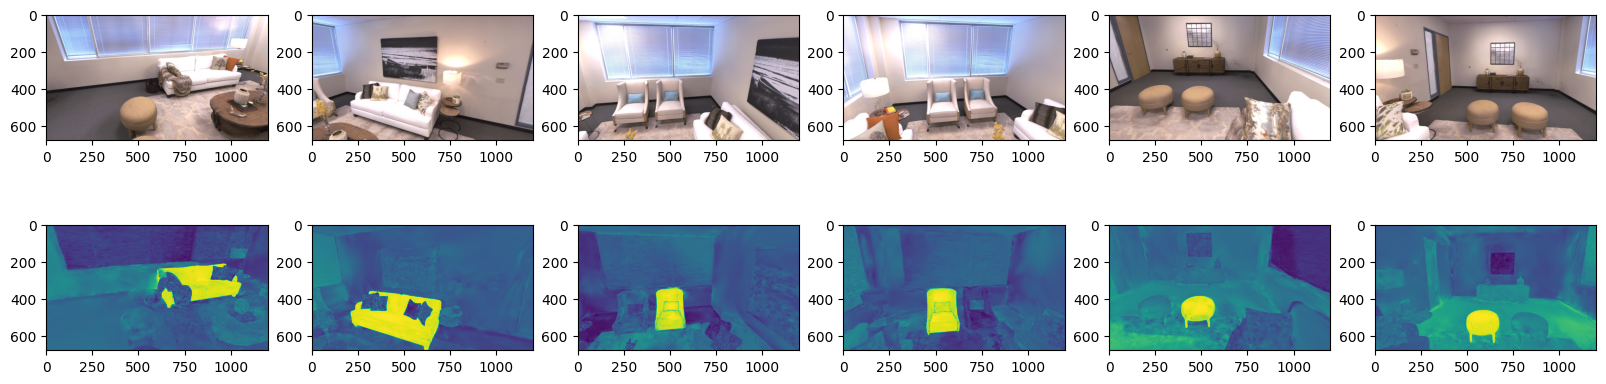

In [18]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")

## SOFA
# ref_img_camera_id = 179
# ref_img_camera_id = 62

## ARMCHAIR
# ref_img_camera_id = 125
# ref_img_camera_id = 144

## OTTOMAN
# ref_img_camera_id = 21
# ref_img_camera_id = 34

plt.figure(figsize=(20, 5))
ref_img_camera_ids = [179, 62, 125, 144, 21, 34]
query_indices = [
    [[300, 850]], 
    [[500, 400]], 
    [[400, 500], [450, 500], [500, 500]], 
    [[400, 500], [450, 500], [500, 500]], 
    [[450, 500]], 
    [[500, 550]]
    ]

## only consider armchair
# ref_img_camera_ids = [125, 144]
# query_indices = [
#     [[400, 500], [450, 500], [500, 500]], 
#     [[400, 500], [450, 500], [500, 500]]
# ]
rendered_features = []
all_similarities = []
for idx, ref_img_camera_id in enumerate(ref_img_camera_ids):
    view = deepcopy(cameras[ref_img_camera_id])

    view.feature_height, view.feature_width = view.image_height, view.image_width
    img = view.original_image * 255
    img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

    bg_color = [0 for i in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]
    rendered_features.append(rendered_feature)

    feature_with_scale = rendered_feature
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])
    normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
    for id, query_index in enumerate(query_indices[idx]):
        query_index = [
            int(query_index[0] / view.image_height * view.feature_height),
            int(query_index[1] / view.image_width * view.feature_width)
            ]
        q_feature = normed_features[query_index[0], query_index[1]].reshape(-1, 1)
        if id == 0:
            query_features = q_feature
        else:
            query_features = torch.cat([query_features, q_feature], dim=-1)
    # print(query_features.shape)
    similarity = normed_features @ query_features # (H, W, k)
    similarity = torch.max(similarity, dim=-1).values

    point_features = feature_gaussians.get_point_features
    scale_conditioned_point_features = point_features
    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
    similarities = normed_scale_conditioned_point_features @ query_features # (N, k)
    similarities = torch.max(similarities, dim=-1).values
    similarities[similarities < 0.5] = 0
    similarities[similarities != 0] = 1

    all_similarities.append(similarities)

    plt.subplot(2, len(ref_img_camera_ids), idx+1)
    plt.imshow(img)
    plt.subplot(2, len(ref_img_camera_ids), idx+1+len(ref_img_camera_ids))
    plt.imshow(similarity.detach().cpu().numpy())

all_similarities = torch.stack(all_similarities, dim=0)
all_similarities = torch.any(all_similarities.bool(), dim=0).int()

# print(all_similarities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


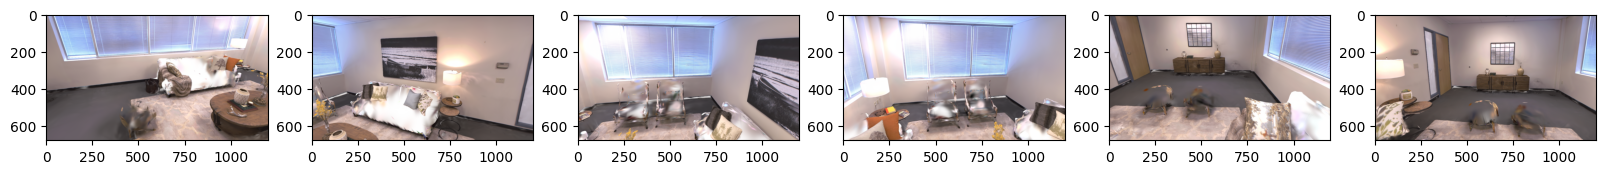

In [19]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(all_similarities == 0)

bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

plt.figure(figsize=(20, 5))
for idx, ref_img_camera_id in enumerate(ref_img_camera_ids):
    rendered_segmented_image = render(cameras[ref_img_camera_id], scene_gaussians, pipeline.extract(args), background)['render']
    plt.subplot(1, len(ref_img_camera_ids), idx+1)
    plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

# scene_gaussians.save_ply("./segmentation_res/background/bg.ply")

from torchvision.transforms.functional import to_pil_image
for i in range(len(cameras)):
    rendered_segmented_image = render(cameras[i], scene_gaussians, pipeline.extract(args), background)['render']
    img_tensor = (rendered_segmented_image * 255).clamp(0, 255).byte()
    img_pil = to_pil_image(img_tensor)
    # img_pil.save(f"./tmp/armchair_{i}.png")

